In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
path = "../parsers/mvideo_parser/unfiltered_features.parquet"

In [4]:
df = pd.read_parquet(path, engine="pyarrow")

In [5]:
df.shape

(933, 104)

In [6]:
df.columns

Index(['brand_name', 'url', 'Заводские данные_Гарантия',
       'Заводские данные_Страна', 'Серия модели_Серия',
       'Операционная система_Операционная система',
       'Операционная система_ОС Windows', 'Процессор_Процессор',
       'Процессор_Количество ядер', 'Процессор_Кэш-память',
       ...
       'Жесткий диск_Объем гибридного SSHD', 'Передача данных_Модуль 3G',
       'Передача данных_Поддержка 4G LTE', 'Передача данных_Поддержка 5G',
       'Интерфейсы_Разъем для микрофона 3.5 мм',
       'Интерфейсы_Выход D-Sub видео', 'Процессор_Платформа Intel Evo',
       'basePrice', 'basePromoPrice', 'salePrice'],
      dtype='object', length=104)

In [7]:
df.head()

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память,...,Жесткий диск_Объем гибридного SSHD,Передача данных_Модуль 3G,Передача данных_Поддержка 4G LTE,Передача данных_Поддержка 5G,Интерфейсы_Разъем для микрофона 3.5 мм,Интерфейсы_Выход D-Sub видео,Процессор_Платформа Intel Evo,basePrice,basePromoPrice,salePrice
30062056,Honor,https://www.mvideo.ru/products/noutbuk-honor-m...,1 год,Китай,MagicBook X 15,Windows 10 Домашняя 64,установлена,Intel Core i5 10210U 1.6 ГГц,4.0,8.0,...,NaN,None,None,None,NaN,NaN,None,69999,NaN,69999
30065211,Thunderobot,https://www.mvideo.ru/products/noutbuk-igrovoi...,1 год,Китай,GAMING,Windows 11 Pro 64,установлена,Intel Core i5 12450H 2.0 ГГц,8.0,12.0,...,NaN,None,None,None,NaN,NaN,None,104999,NaN,104999
30056687,Honor,https://www.mvideo.ru/products/noutbuk-honor-m...,1 год,Китай,MagicBook X15,Windows 10 Домашняя 64,установлена,Intel Core i5 10210U 1.6 ГГц,4.0,6.0,...,NaN,None,None,None,NaN,NaN,None,59999,NaN,59999
30064594,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro,macOS,None,Apple M2,8.0,NaN,...,NaN,None,None,None,NaN,NaN,None,139999,NaN,139999
30061606,MSI,https://www.mvideo.ru/products/noutbuk-igrovoi...,1 год,Китай,Katana GF76,Windows 11 Домашняя 64,установлена,Intel Core i5 11400H 2.7 ГГц,6.0,12.0,...,NaN,None,None,None,NaN,NaN,None,129999,109999.0,109999


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Columns: 104 entries, brand_name to salePrice
dtypes: float64(43), int64(3), object(58)
memory usage: 765.4+ KB


# Посмотрим цены

In [9]:
prices = ["basePrice", "basePromoPrice", "salePrice"]

In [10]:
df[prices].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   basePrice       933 non-null    int64  
 1   basePromoPrice  284 non-null    float64
 2   salePrice       933 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 29.2 KB


In [11]:
df[prices].describe()

,basePrice,basePromoPrice,salePrice
count,933.000000,284.000000,933.000000
mean,100040.727760,60874.056338,94574.072883
std,77385.125221,50154.053201,75593.497117
min,6225.000000,4360.000000,4360.000000
25%,44999.000000,25999.000000,39999.000000
50%,79990.000000,48999.000000,70799.000000
75%,135990.000000,75499.250000,135990.000000
max,549999.000000,325500.000000,549999.000000


In [12]:
df.loc[~df.basePromoPrice.isna(), prices]

,basePrice,basePromoPrice,salePrice
30061606,129999,109999.0,109999
30057684,25999,19999.0,19999
30063454,32999,29999.0,29999
30063451,24999,21999.0,21999
30062427,32999,29999.0,29999
...,...,...,...
30055872,79599,55720.0,55720
30056520,32999,23100.0,23100
30055290,264499,185150.0,185150
30055117,102499,71750.0,71750


**Получается есть 2 цены, базовая цена и цена продажи**  
В модели можно будет использовать любую из них  
Я далее буду смотреть `basePrice`

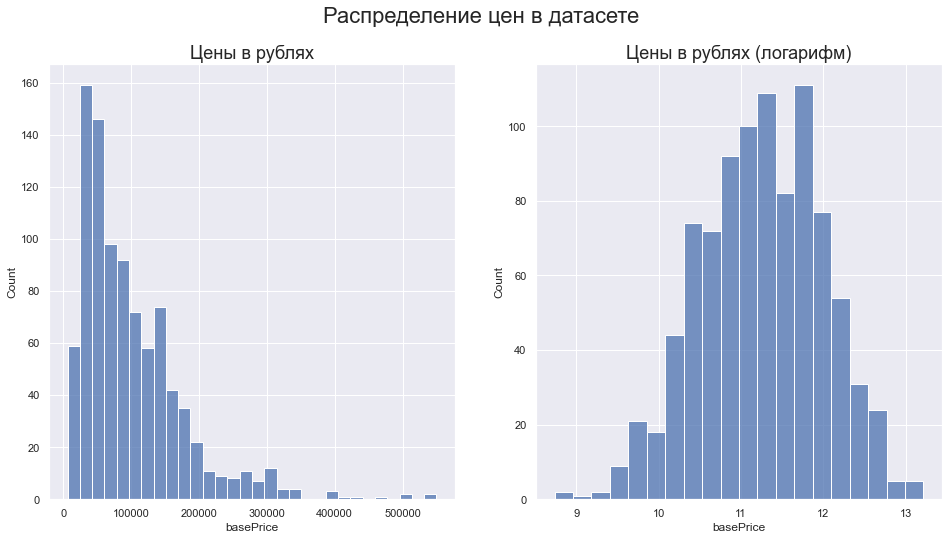

In [13]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Распределение цен в датасете', size=22)
axes[0].set_title("Цены в рублях", size=18)
sns.histplot(df.basePrice, ax=axes[0]);
axes[1].set_title("Цены в рублях (логарифм)", size=18)
sns.histplot(np.log1p(df.basePrice), ax=axes[1]);

Распределение логарифмическое, с тяжелоым правым хвостом. возможно стоит предсказывать логарифм цены. а потом его преобразовывать

# Анализ фич
Сделаем переменную, в которую отбираем полезные фичи

In [14]:
useful_features = set()

# Посмотрим первые 10 фич

In [15]:
current_features = df.columns[0:10]

In [16]:
df[current_features].head()

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память
30062056,Honor,https://www.mvideo.ru/products/noutbuk-honor-m...,1 год,Китай,MagicBook X 15,Windows 10 Домашняя 64,установлена,Intel Core i5 10210U 1.6 ГГц,4.0,8.0
30065211,Thunderobot,https://www.mvideo.ru/products/noutbuk-igrovoi...,1 год,Китай,GAMING,Windows 11 Pro 64,установлена,Intel Core i5 12450H 2.0 ГГц,8.0,12.0
30056687,Honor,https://www.mvideo.ru/products/noutbuk-honor-m...,1 год,Китай,MagicBook X15,Windows 10 Домашняя 64,установлена,Intel Core i5 10210U 1.6 ГГц,4.0,6.0
30064594,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro,macOS,None,Apple M2,8.0,NaN
30061606,MSI,https://www.mvideo.ru/products/noutbuk-igrovoi...,1 год,Китай,Katana GF76,Windows 11 Домашняя 64,установлена,Intel Core i5 11400H 2.7 ГГц,6.0,12.0


In [17]:
df[current_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   brand_name                                 933 non-null    object 
 1   url                                        933 non-null    object 
 2   Заводские данные_Гарантия                  933 non-null    object 
 3   Заводские данные_Страна                    933 non-null    object 
 4   Серия модели_Серия                         776 non-null    object 
 5   Операционная система_Операционная система  919 non-null    object 
 6   Операционная система_ОС Windows            728 non-null    object 
 7   Процессор_Процессор                        933 non-null    object 
 8   Процессор_Количество ядер                  930 non-null    float64
 9   Процессор_Кэш-память                       775 non-null    float64
dtypes: float64(2), 

## brand_name

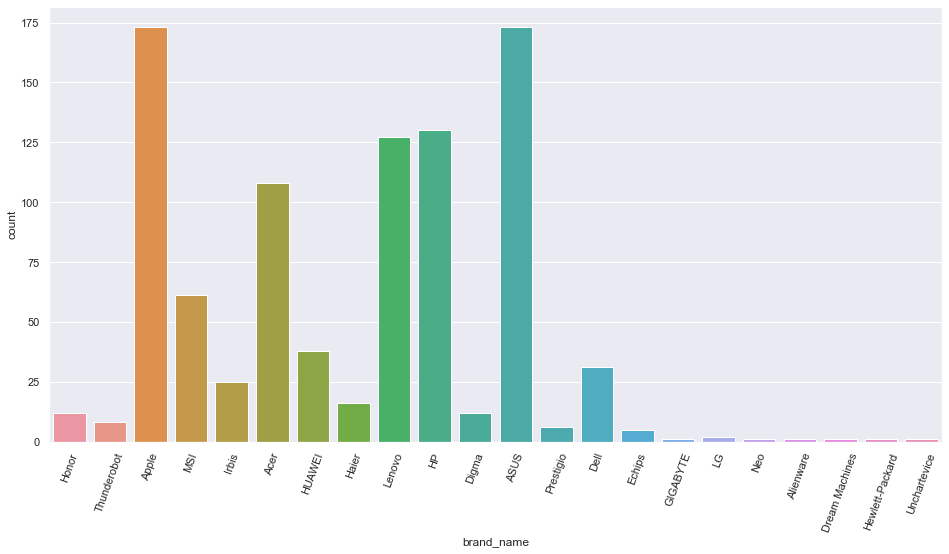

In [18]:
sns.countplot(x=df.brand_name)
plt.xticks(rotation = 70)
plt.show()

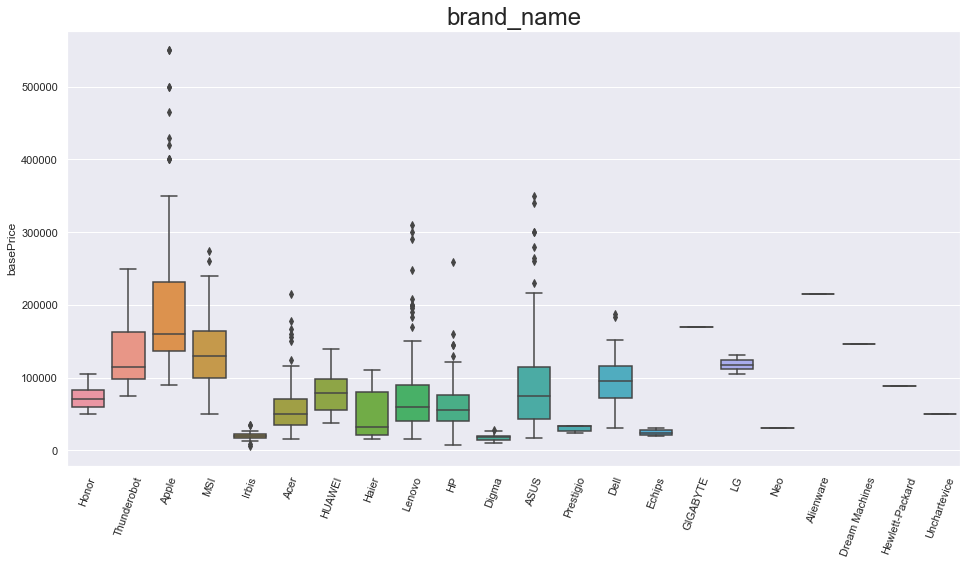

In [19]:
sns.boxplot(data=df, x="brand_name", y="basePrice")
plt.title("brand_name", size=24)
plt.xticks(rotation = 70)
plt.xlabel("")
plt.show()

Бренд очень важная характеристика для ноутубука и эту фичу точно стоит использовать.  
По поводу редких брендов, возможно стоит их исключить, т.к. очень мало данных по ним.

In [20]:
def analyze_cat_feature(feature_name):
    sns.boxplot(data=df, x=feature_name, y="basePrice")
    plt.title(feature_name, size=24)
    plt.xticks(rotation = 70)
    plt.xlabel("")
    plt.show()

## Остальные категориальные фичи

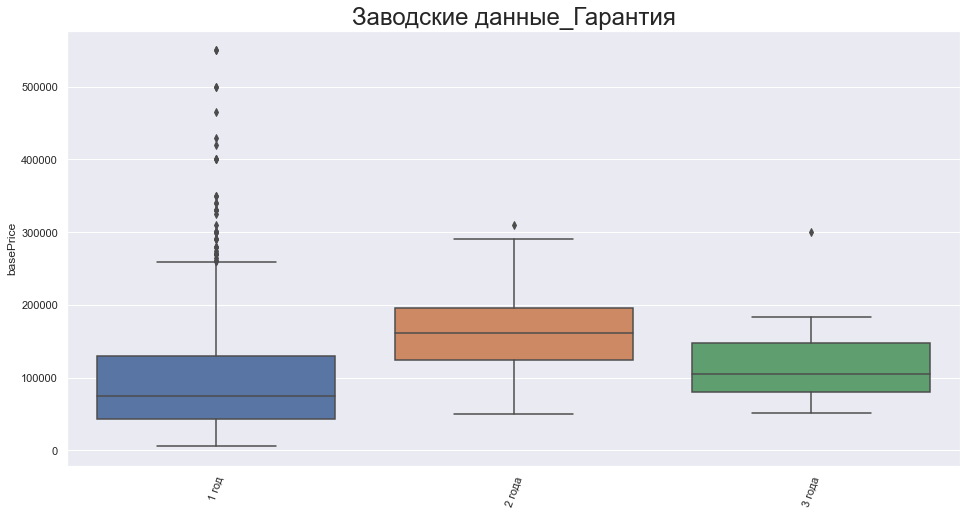

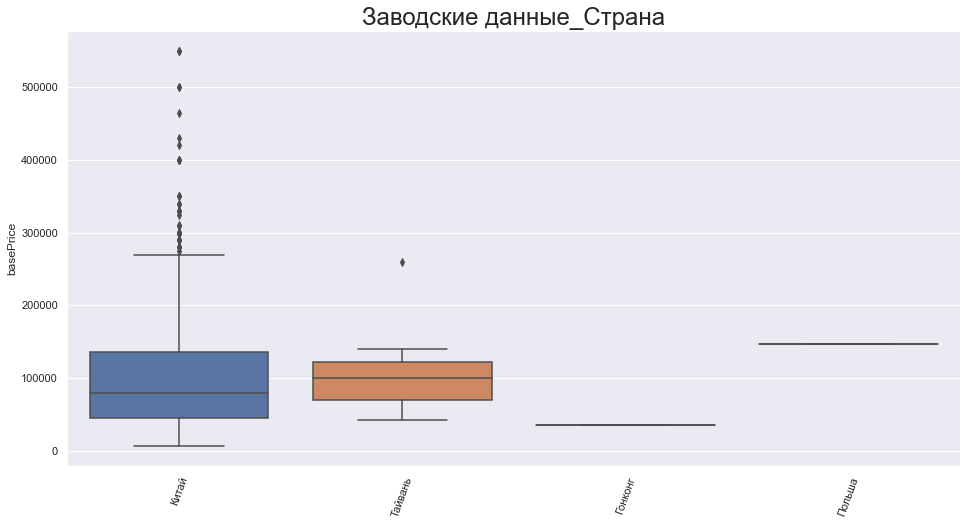

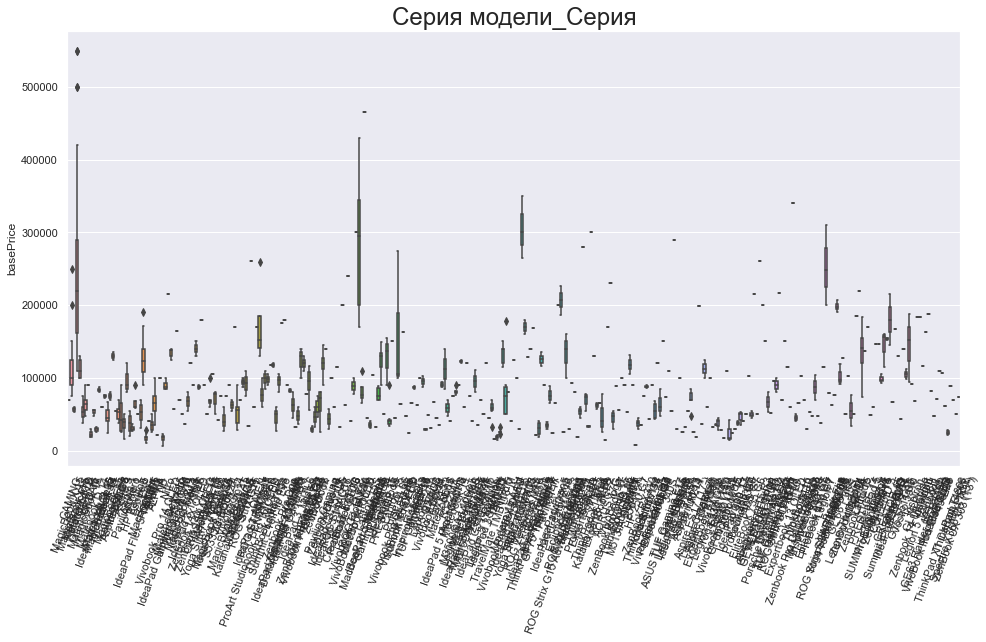

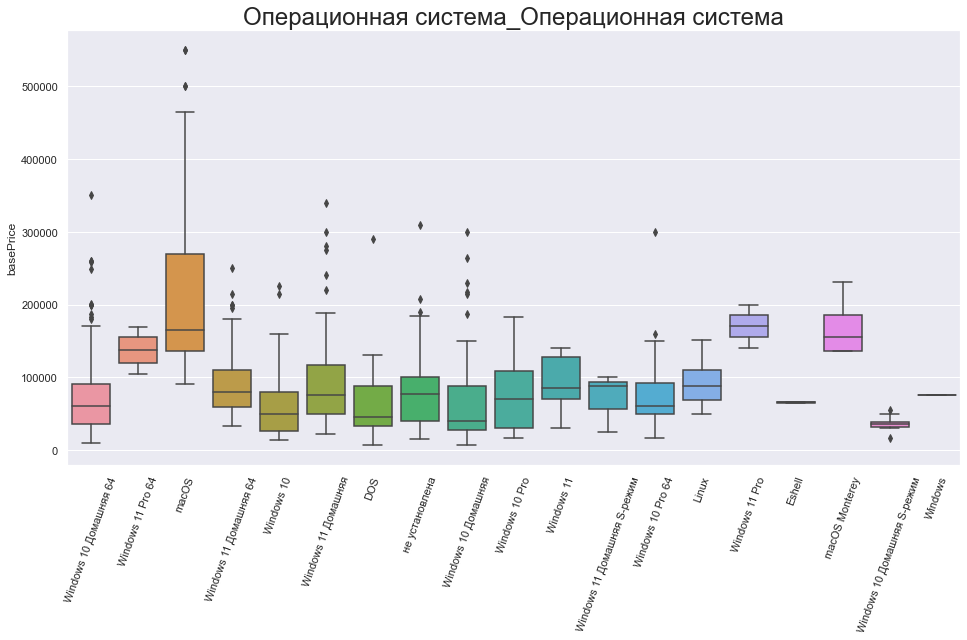

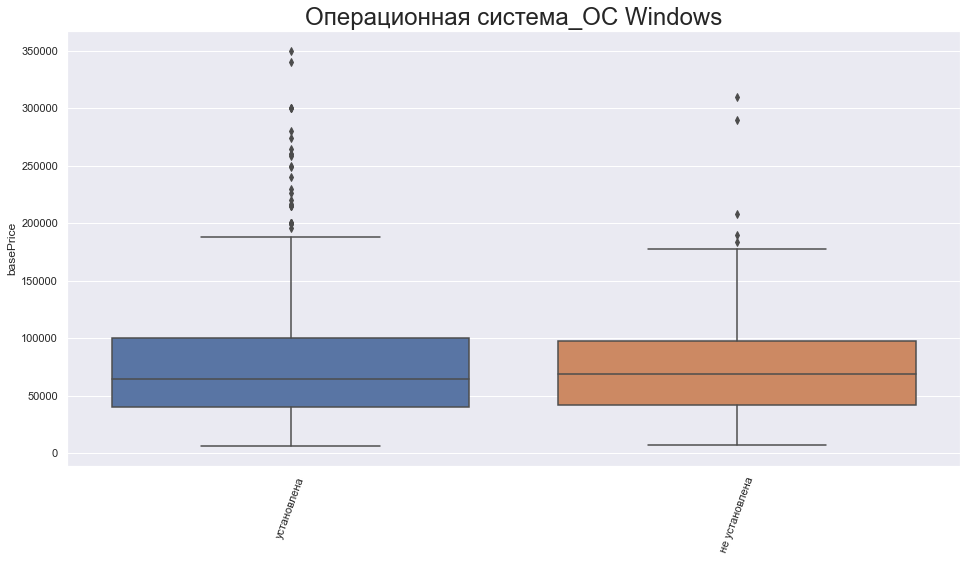

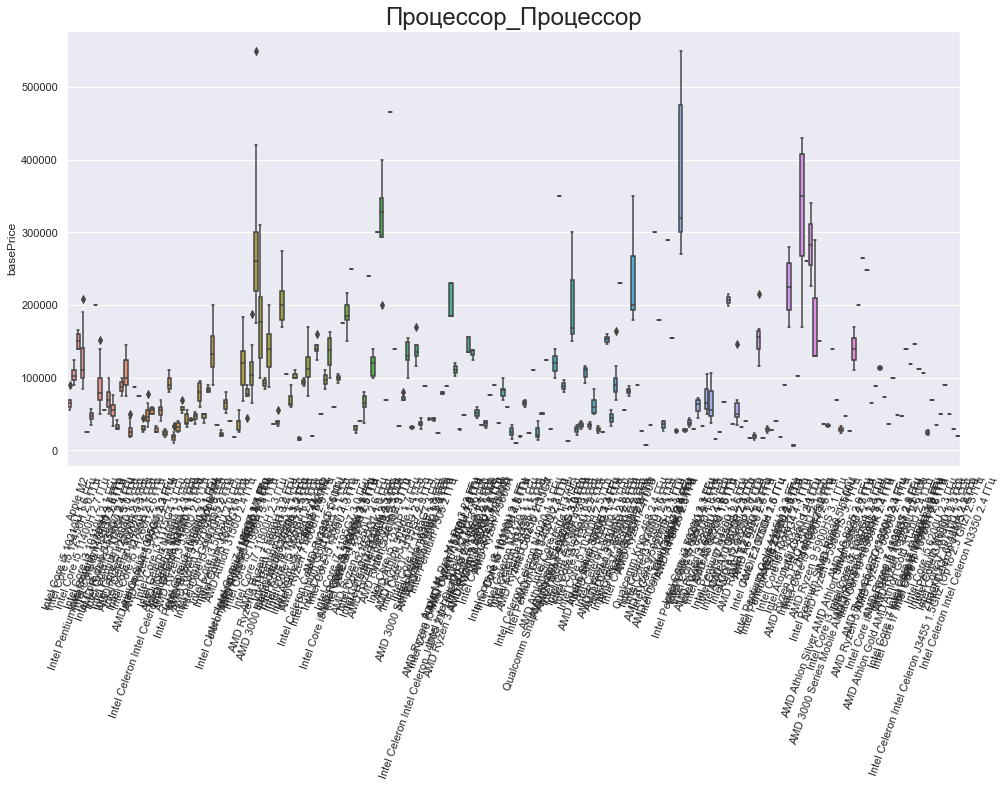

In [21]:
for feature in current_features[2:8]:
    analyze_cat_feature(feature)

Из Процессор_Процессор можно вытащить модель Intel, AMD, ну или сгруппировать, чтобы было меньше вариантов

In [22]:
df["Процессор_Процессор_crop"] = df["Процессор_Процессор"].apply(lambda x:" ".join(x.split()[:2]))

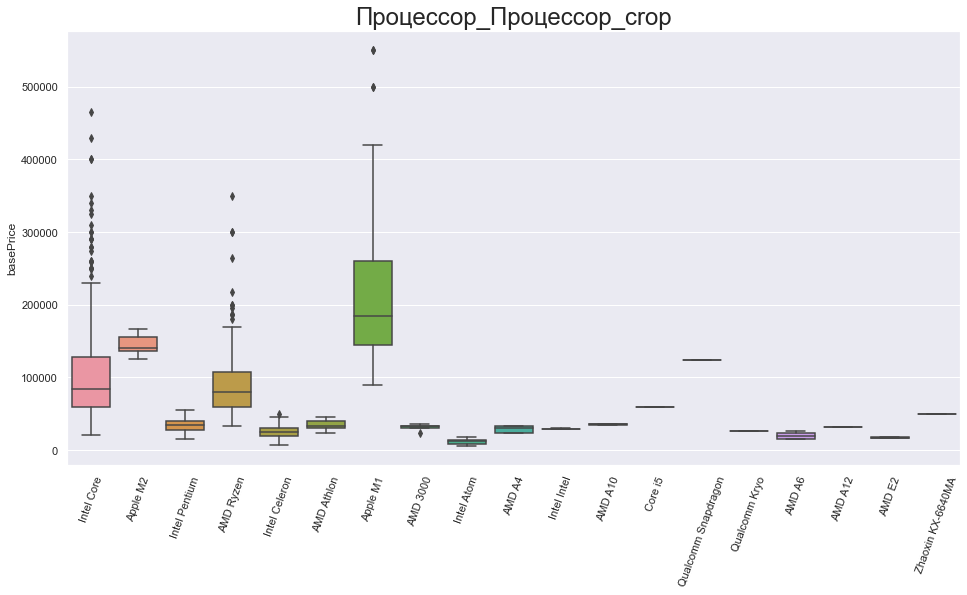

In [23]:
analyze_cat_feature("Процессор_Процессор_crop")

## Числовые фичи

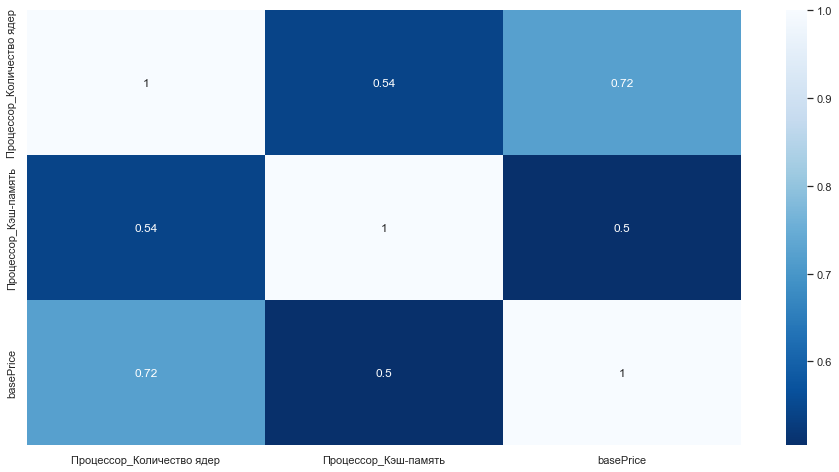

In [24]:
numerical_feats = current_features[8:10]

sns.heatmap(df[list(numerical_feats) +  ["basePrice"]].corr(), cmap="Blues_r", annot=True)
plt.show()

In [25]:
df[numerical_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Процессор_Количество ядер  930 non-null    float64
 1   Процессор_Кэш-память       775 non-null    float64
dtypes: float64(2)
memory usage: 21.9 KB


## Заполнить пропуски в количестве ядер

In [26]:
df[df["Процессор_Количество ядер"].isna()]

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память,...,Передача данных_Модуль 3G,Передача данных_Поддержка 4G LTE,Передача данных_Поддержка 5G,Интерфейсы_Разъем для микрофона 3.5 мм,Интерфейсы_Выход D-Sub видео,Процессор_Платформа Intel Evo,basePrice,basePromoPrice,salePrice,Процессор_Процессор_crop
30039239,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro Touch Bar,macOS,None,Intel Core i9 2.9 ГГц,NaN,12.0,...,None,None,None,NaN,NaN,None,464999,325500.0,325500,Intel Core
30044326,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro,macOS,None,Intel Core i7 2.8 ГГц,NaN,NaN,...,None,None,None,NaN,NaN,None,154999,NaN,154999,Intel Core
30045154,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro,macOS,None,Intel Core i7 1.7 ГГц,NaN,NaN,...,None,None,None,NaN,NaN,None,169999,NaN,169999,Intel Core


In [27]:
df[df["Серия модели_Серия"] == "MacBook Pro"]["Процессор_Количество ядер"].value_counts()

10.0    30
8.0     25
4.0      9
Name: Процессор_Количество ядер, dtype: int64

Количество ядер можно заполнить вручную, т.к. всего 3 трех макбуков оно не заполнено  
Фича полезная, т.к. неплохо коррелирует с ценой  
Объем кеш памяти не будем включать (пока)  

In [28]:
df.loc[((df["Серия модели_Серия"] == "MacBook Pro") | ((df["Серия модели_Серия"] == "MacBook Pro Touch Bar"))) & (df["Процессор_Количество ядер"].isna()), "Процессор_Количество ядер"] = 10

In [29]:
df[df["Процессор_Количество ядер"].isna()]

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память,...,Передача данных_Модуль 3G,Передача данных_Поддержка 4G LTE,Передача данных_Поддержка 5G,Интерфейсы_Разъем для микрофона 3.5 мм,Интерфейсы_Выход D-Sub видео,Процессор_Платформа Intel Evo,basePrice,basePromoPrice,salePrice,Процессор_Процессор_crop


## Обновим список полезных фич

In [30]:
current_features

Index(['brand_name', 'url', 'Заводские данные_Гарантия',
       'Заводские данные_Страна', 'Серия модели_Серия',
       'Операционная система_Операционная система',
       'Операционная система_ОС Windows', 'Процессор_Процессор',
       'Процессор_Количество ядер', 'Процессор_Кэш-память'],
      dtype='object')

In [31]:
useful_features.update([
    "brand_name",
    "Заводские данные_Гарантия",
    "Заводские данные_Страна",
    "Операционная система_Операционная система",
    "Процессор_Процессор_crop",
    "Процессор_Количество ядер"
])


In [32]:
df[list(useful_features)]

,Процессор_Количество ядер,Заводские данные_Страна,brand_name,Заводские данные_Гарантия,Операционная система_Операционная система,Процессор_Процессор_crop
30062056,4.0,Китай,Honor,1 год,Windows 10 Домашняя 64,Intel Core
30065211,8.0,Китай,Thunderobot,1 год,Windows 11 Pro 64,Intel Core
30056687,4.0,Китай,Honor,1 год,Windows 10 Домашняя 64,Intel Core
30064594,8.0,Китай,Apple,1 год,macOS,Apple M2
30061606,6.0,Китай,MSI,1 год,Windows 11 Домашняя 64,Intel Core
...,...,...,...,...,...,...
400027919,8.0,Китай,Apple,1 год,macOS Monterey,Apple M2
4183550,4.0,Китай,Echips,1 год,Windows 10 Домашняя,Intel Celeron
400027896,10.0,Китай,Apple,1 год,macOS Monterey,Apple M1
400029644,10.0,Китай,Apple,1 год,macOS Monterey,Apple M1


# Смотрим фичи 10-19

In [33]:
current_features = df.columns[10:20]

In [34]:
df[current_features].head()

,Видеокарта_Производитель видеопроцессора,Видеокарта_Графический контроллер,Экран_Диагональ/разрешение,Экран_Диагональ экрана,Экран_Технология экрана,Экран_Частота обновления,Экран_Матовый экран,Жесткий диск_Объем SSD,Оперативная память_Оперативная память (RAM),Оперативная память_Частота памяти
30062056,Intel,Intel UHD Graphics,"15.6""/1920x1080 пикс.","15.6""(39.6 см)",IPS,60.0,Да,512 ГБ,16,2666.0
30065211,NVIDIA,GeForce RTX 3050 Ti для ноутбуков 4GB,"17.3""/1920x1080 пикс.","17.3""(43.9 см)",AHVA,144.0,Да,512 ГБ,16,3200.0
30056687,Intel,Intel UHD Graphics,"15.6""/1920x1080 пикс.","15.6""(39.6 см)",IPS,60.0,Да,512 ГБ,8,2400.0
30064594,None,None,"13.3""/2560x1600 пикс.",None,IPS,NaN,None,256 ГБ,8,NaN
30061606,NVIDIA,GeForce RTX 3060 для ноутбуков 6GB,"17.3""/1920x1080 пикс.","17.3""(43.9 см)",IPS,144.0,Да,512 ГБ,16,3200.0


In [35]:
df[current_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Видеокарта_Производитель видеопроцессора     823 non-null    object 
 1   Видеокарта_Графический контроллер            846 non-null    object 
 2   Экран_Диагональ/разрешение                   932 non-null    object 
 3   Экран_Диагональ экрана                       749 non-null    object 
 4   Экран_Технология экрана                      893 non-null    object 
 5   Экран_Частота обновления                     538 non-null    float64
 6   Экран_Матовый экран                          578 non-null    object 
 7   Жесткий диск_Объем SSD                       832 non-null    object 
 8   Оперативная память_Оперативная память (RAM)  933 non-null    int64  
 9   Оперативная память_Частота памяти            740 non-null    floa

In [36]:
list(current_features[0:5]) + list(current_features[6:8])

['Видеокарта_Производитель видеопроцессора',
 'Видеокарта_Графический контроллер',
 'Экран_Диагональ/разрешение',
 'Экран_Диагональ экрана',
 'Экран_Технология экрана',
 'Экран_Матовый экран',
 'Жесткий диск_Объем SSD']

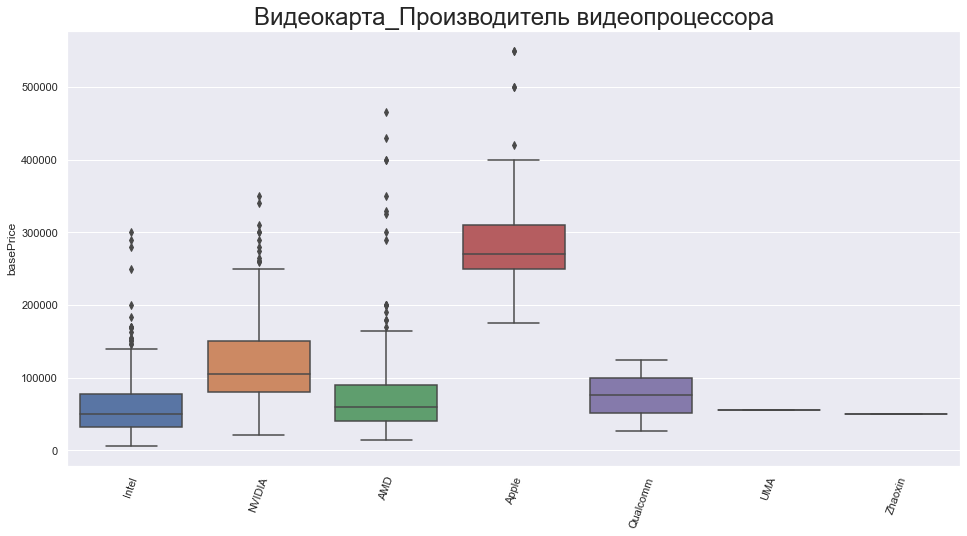

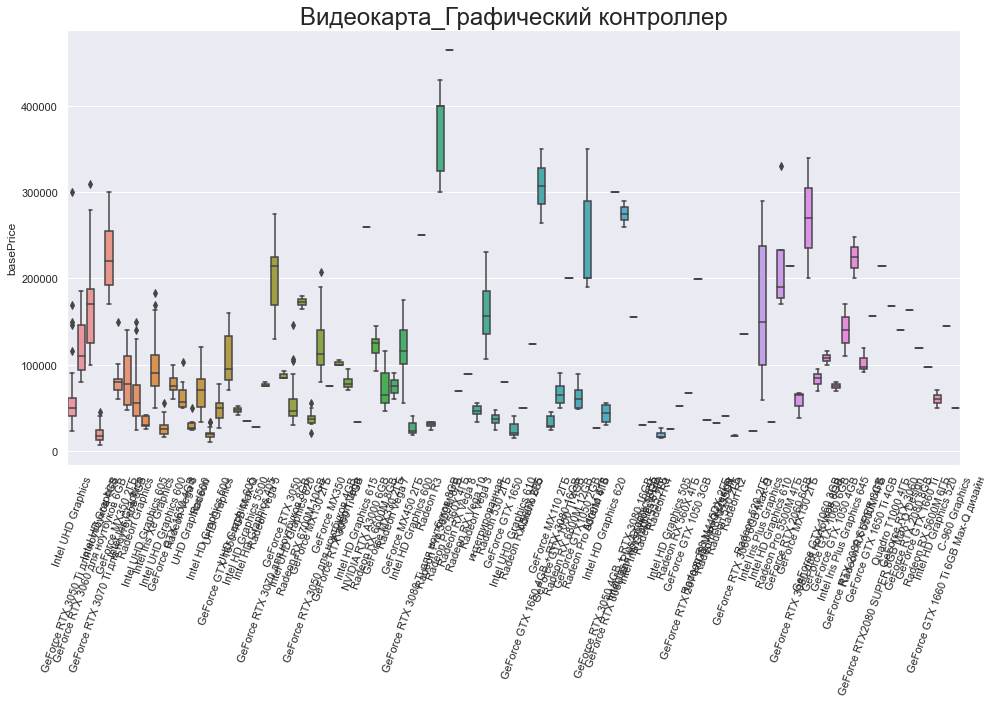

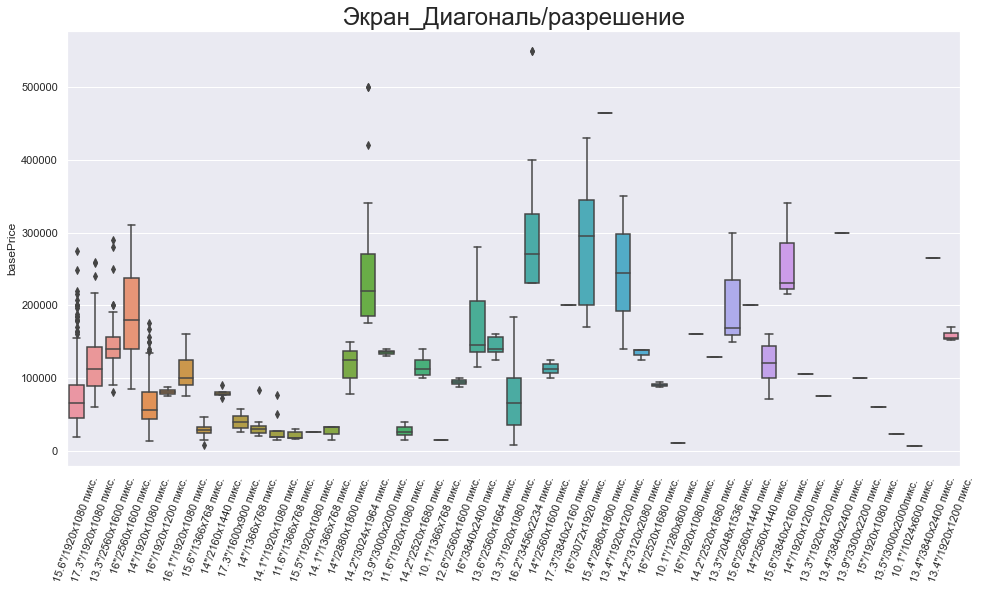

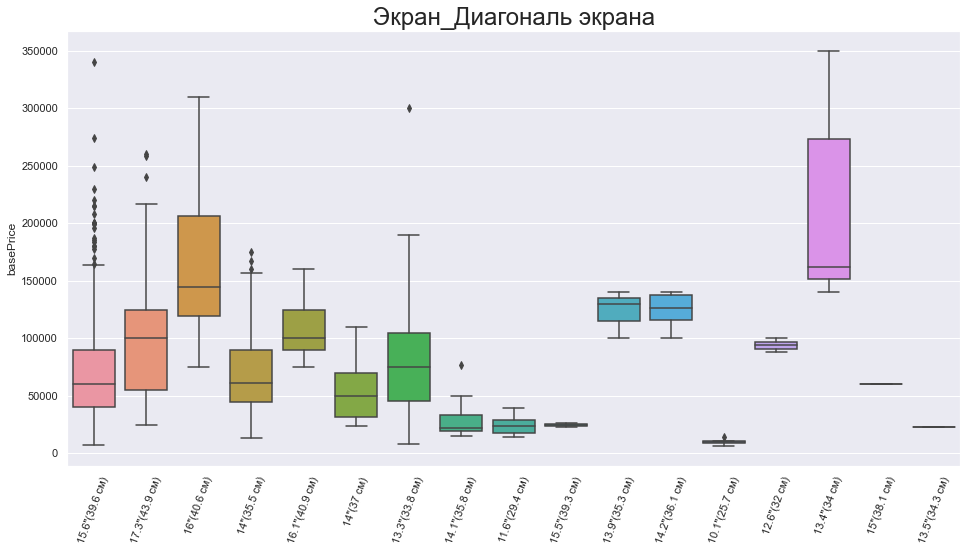

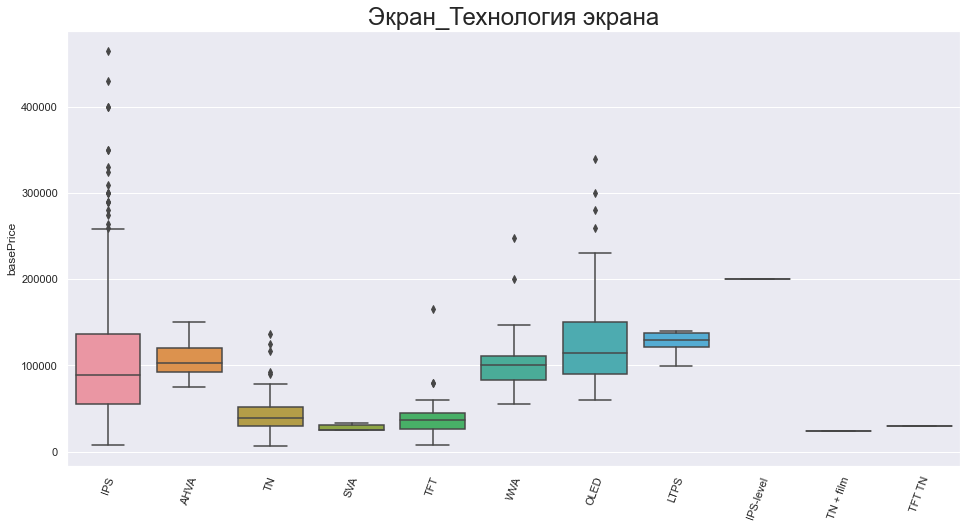

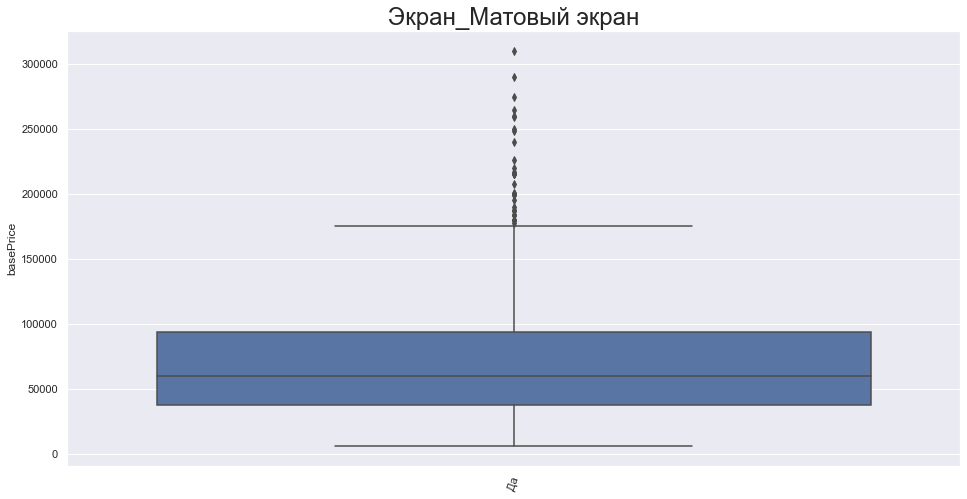

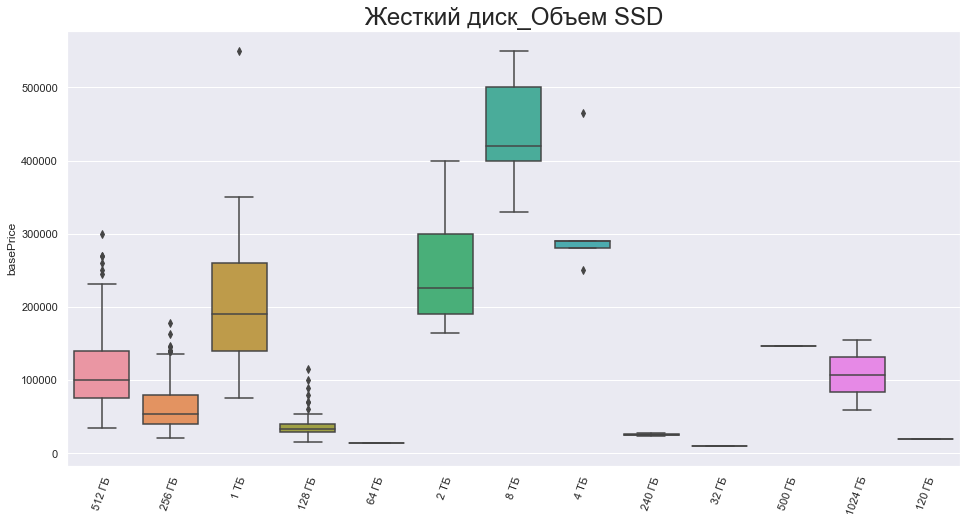

In [37]:
for feature in list(current_features[0:5]) + list(current_features[6:8]):
    analyze_cat_feature(feature)

Можно сделать числовые фичи по объему SSD, диагонали экрана.  
Из видеокарты взять первые 2 слова


In [38]:
df["Видеокарта_Графический контроллер_crop"] = df["Видеокарта_Графический контроллер"].fillna("").apply(lambda x:" ".join(x.split()[:2]))

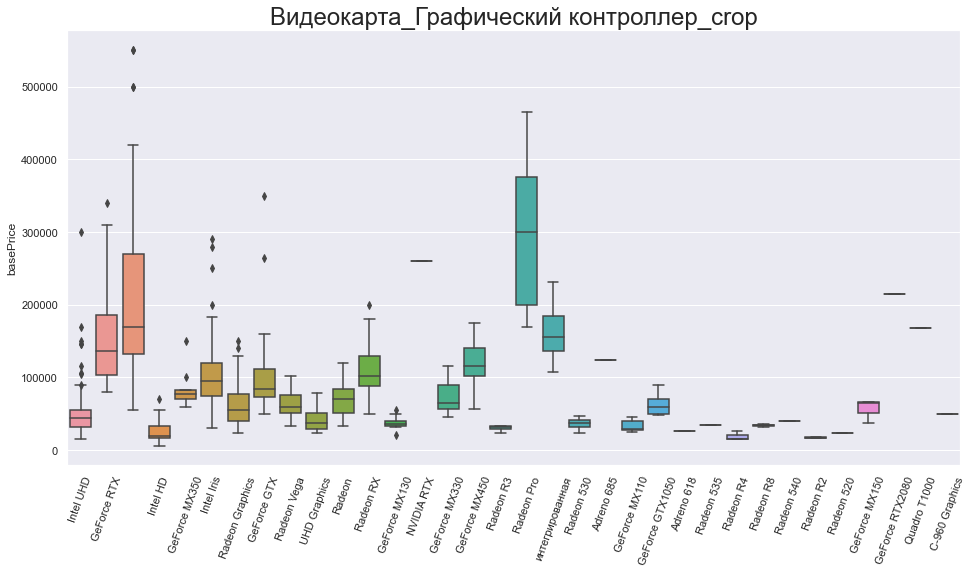

In [39]:
analyze_cat_feature("Видеокарта_Графический контроллер_crop")

## Преобразуем в числове признаки: диагональ и Объем SSD

Если не указана заполним самой популярной

In [40]:
df["Экран_Диагональ экрана"].value_counts()

15.6"(39.6 см)    359
14"(35.5 см)      160
17.3"(43.9 см)     65
13.3"(33.8 см)     41
16"(40.6 см)       28
14"(37 см)         23
11.6"(29.4 см)     18
14.1"(35.8 см)     15
16.1"(40.9 см)     11
14.2"(36.1 см)      8
13.4"(34 см)        8
10.1"(25.7 см)      4
13.9"(35.3 см)      3
15.5"(39.3 см)      2
12.6"(32 см)        2
15"(38.1 см)        1
13.5"(34.3 см)      1
Name: Экран_Диагональ экрана, dtype: int64

In [41]:
df["Экран_Диагональ экрана_num"] = df["Экран_Диагональ экрана"].fillna("").apply(lambda x: 15.6 if x == "" else float(x.split('"')[0]))

In [42]:
def convert_volume_to_number(val):
    if not val:
        return 0
    num, item = val.split()
    num = int(num)
    if item.lower() == "тб":
        return 1024 * num
    else:
        return num

In [43]:
df["Жесткий диск_Объем SSD_num"] = df["Жесткий диск_Объем SSD"].apply(convert_volume_to_number)

## Числовые фичи

In [44]:
numerical_feats = [
    "Экран_Частота обновления",
    "Оперативная память_Оперативная память (RAM)",
    "Оперативная память_Частота памяти",
    "Экран_Диагональ экрана_num",
    "Жесткий диск_Объем SSD_num"   
]

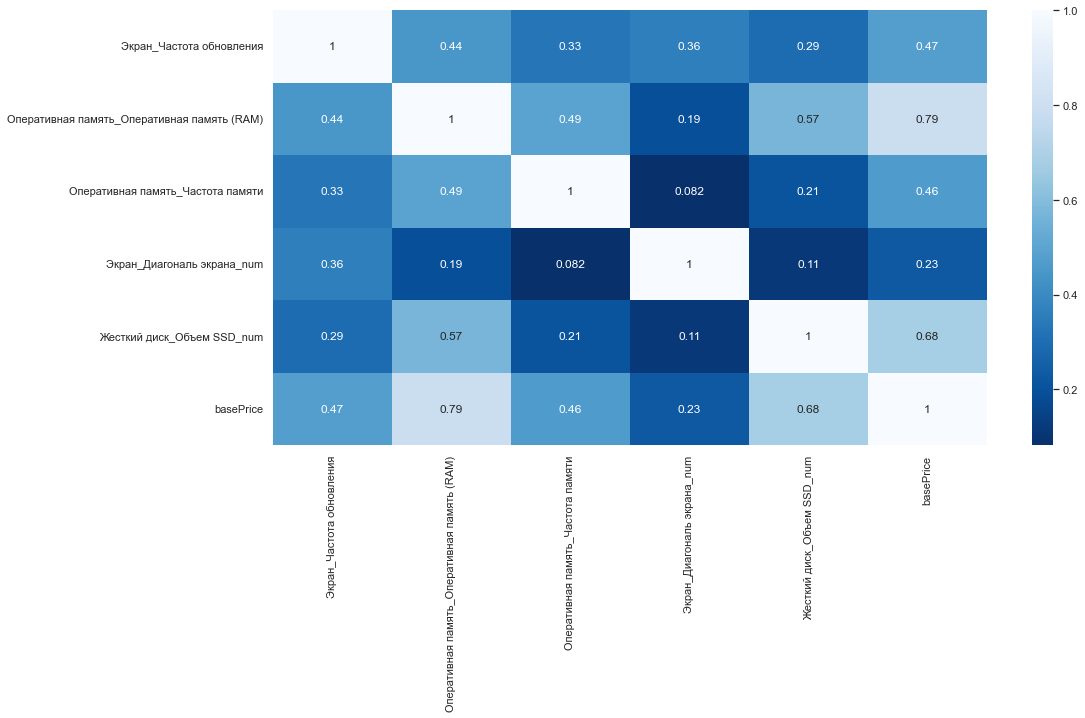

In [45]:
sns.heatmap(df[list(numerical_feats) +  ["basePrice"]].corr(), cmap="Blues_r", annot=True)
plt.show()

<AxesSubplot:xlabel='Экран_Частота обновления', ylabel='basePrice'>

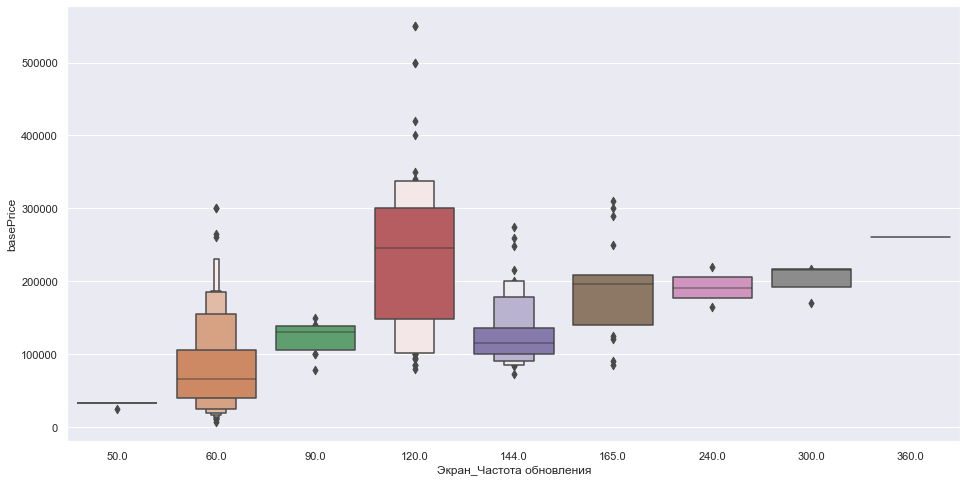

In [46]:

sns.boxenplot(data=df, x="Экран_Частота обновления", y="basePrice")

<AxesSubplot:xlabel='Экран_Диагональ экрана_num', ylabel='basePrice'>

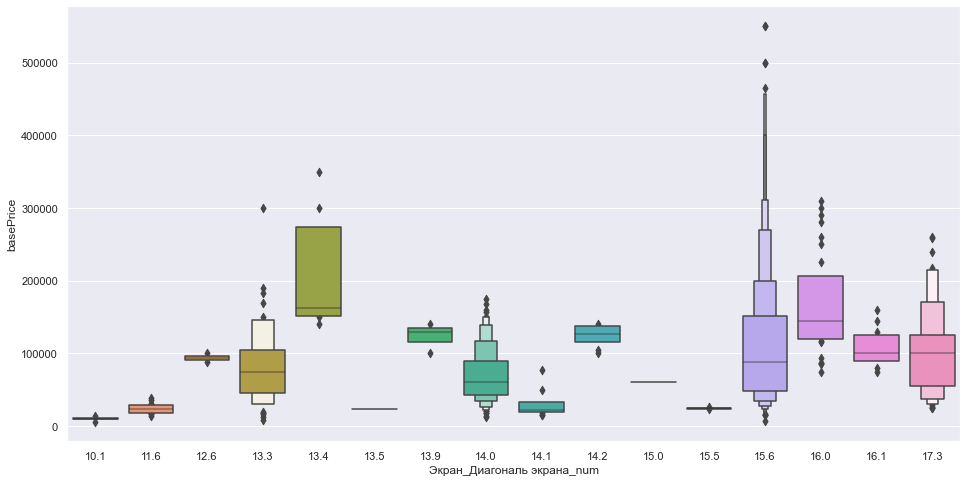

In [47]:
sns.boxenplot(data=df, x="Экран_Диагональ экрана_num", y="basePrice")

In [48]:
useful_features.update([
    "Видеокарта_Графический контроллер_crop",
    "Видеокарта_Производитель видеопроцессора",
    "Экран_Диагональ экрана_num",
    "Оперативная память_Оперативная память (RAM)",
    "Жесткий диск_Объем SSD_num",
    "Экран_Частота обновления",
    "Оперативная память_Частота памяти"
])


In [49]:
df[list(useful_features)]

,Процессор_Количество ядер,Заводские данные_Страна,Видеокарта_Графический контроллер_crop,brand_name,Заводские данные_Гарантия,Оперативная память_Оперативная память (RAM),Видеокарта_Производитель видеопроцессора,Операционная система_Операционная система,Процессор_Процессор_crop,Экран_Диагональ экрана_num,Жесткий диск_Объем SSD_num,Оперативная память_Частота памяти,Экран_Частота обновления
30062056,4.0,Китай,Intel UHD,Honor,1 год,16,Intel,Windows 10 Домашняя 64,Intel Core,15.6,512,2666.0,60.0
30065211,8.0,Китай,GeForce RTX,Thunderobot,1 год,16,NVIDIA,Windows 11 Pro 64,Intel Core,17.3,512,3200.0,144.0
30056687,4.0,Китай,Intel UHD,Honor,1 год,8,Intel,Windows 10 Домашняя 64,Intel Core,15.6,512,2400.0,60.0
30064594,8.0,Китай,,Apple,1 год,8,None,macOS,Apple M2,15.6,256,NaN,NaN
30061606,6.0,Китай,GeForce RTX,MSI,1 год,16,NVIDIA,Windows 11 Домашняя 64,Intel Core,17.3,512,3200.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
400027919,8.0,Китай,интегрированная,Apple,1 год,8,None,macOS Monterey,Apple M2,15.6,256,NaN,60.0
4183550,4.0,Китай,Intel HD,Echips,1 год,8,Intel,Windows 10 Домашняя,Intel Celeron,15.6,240,NaN,60.0
400027896,10.0,Китай,интегрированная,Apple,1 год,16,None,macOS Monterey,Apple M1,15.6,512,NaN,60.0
400029644,10.0,Китай,интегрированная,Apple,1 год,16,None,macOS Monterey,Apple M1,15.6,512,NaN,60.0


# Смотрим фичи 20-29

In [50]:
current_features = df.columns[20:30]

In [51]:
df[current_features].head()

,Оперативная память_Тип оперативной памяти,Передача данных_Поддержка Wi-Fi,Передача данных_Версия Bluetooth,Безопасность_Датчик отпечатков пальцев,Интерфейсы_Выход HDMI,Интерфейсы_Количество портов USB 3.0 тип A,Интерфейсы_Количество портов USB 3.0 тип C,Интерфейсы_Разъем для наушников/микрофона 3.5мм,Корпус_Материал корпуса,Электропитание_Работа от аккумулятора
30062056,DDR4,a/b/g/n/ac,5.0,Да,1.0,2.0,1.0,1.0,алюминиевый сплав,до 7 часов
30065211,DDR4,a/b/g/n/ac/ax,5.0,None,1.0,NaN,NaN,1.0,ABS-пластик,до 5 часов
30056687,DDR4,a/b/g/n/ac,5.0,Да,1.0,1.0,NaN,1.0,алюминиевый сплав,до 7 часов
30064594,None,a/b/g/n/ac/ax,5.0,None,NaN,NaN,NaN,NaN,алюминий,до 20 часов
30061606,DDR4 SO-DIMM,a/b/g/n/ac/ax,5.2,None,1.0,NaN,NaN,1.0,металл/ пластик,до 5 часов


In [52]:
df[current_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Оперативная память_Тип оперативной памяти        777 non-null    object 
 1   Передача данных_Поддержка Wi-Fi                  864 non-null    object 
 2   Передача данных_Версия Bluetooth                 869 non-null    object 
 3   Безопасность_Датчик отпечатков пальцев           263 non-null    object 
 4   Интерфейсы_Выход HDMI                            581 non-null    float64
 5   Интерфейсы_Количество портов USB 3.0 тип A       176 non-null    float64
 6   Интерфейсы_Количество портов USB 3.0 тип C       66 non-null     float64
 7   Интерфейсы_Разъем для наушников/микрофона 3.5мм  710 non-null    float64
 8   Корпус_Материал корпуса                          930 non-null    object 
 9   Электропитание_Работа

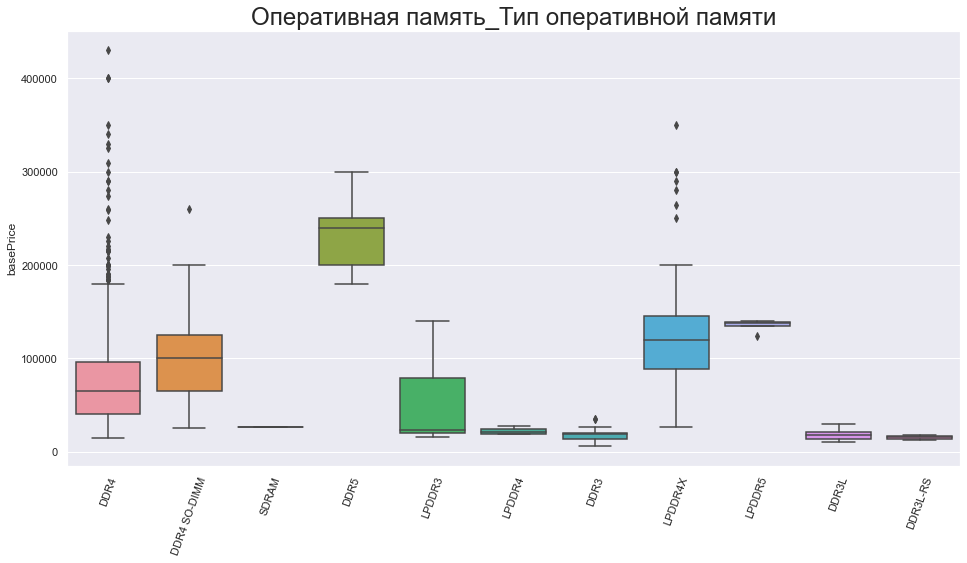

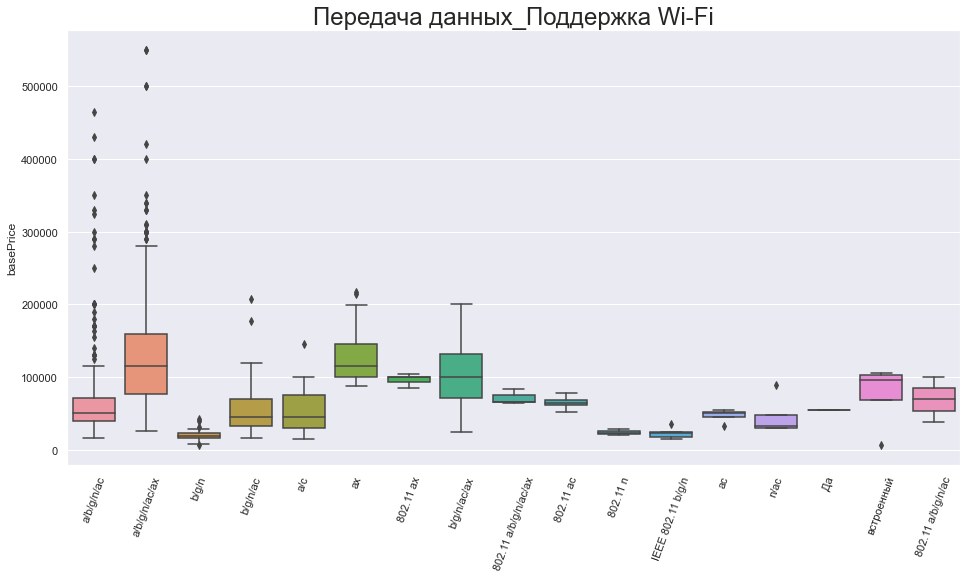

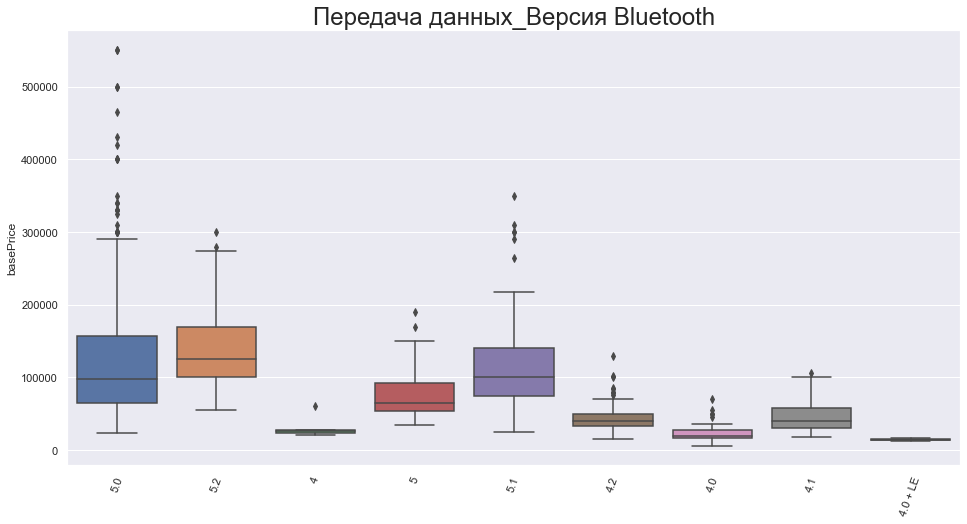

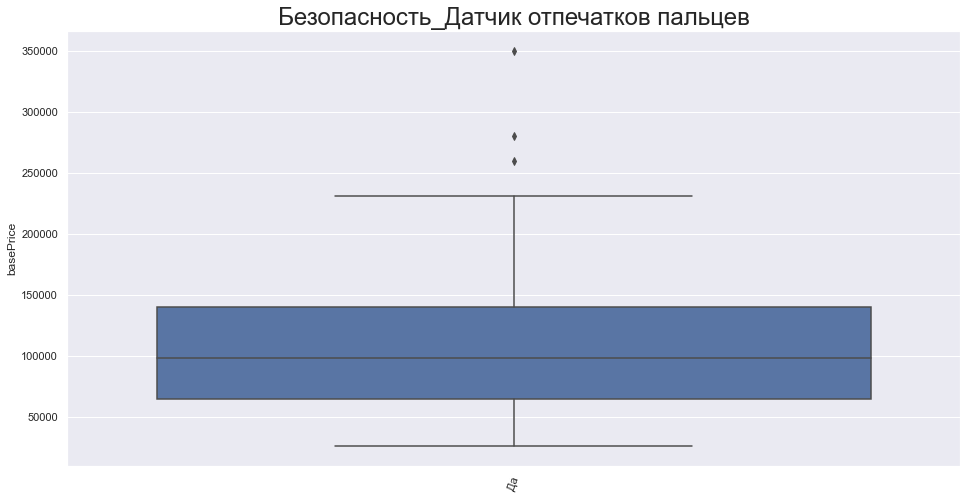

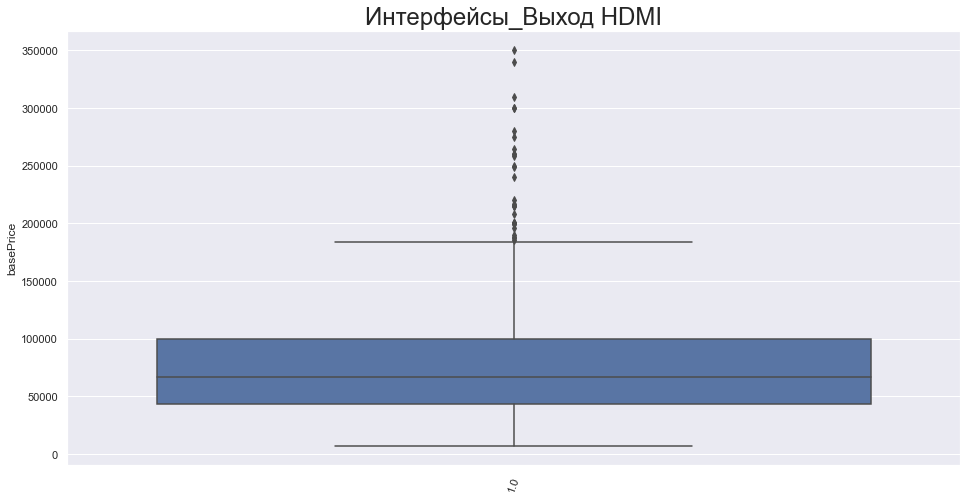

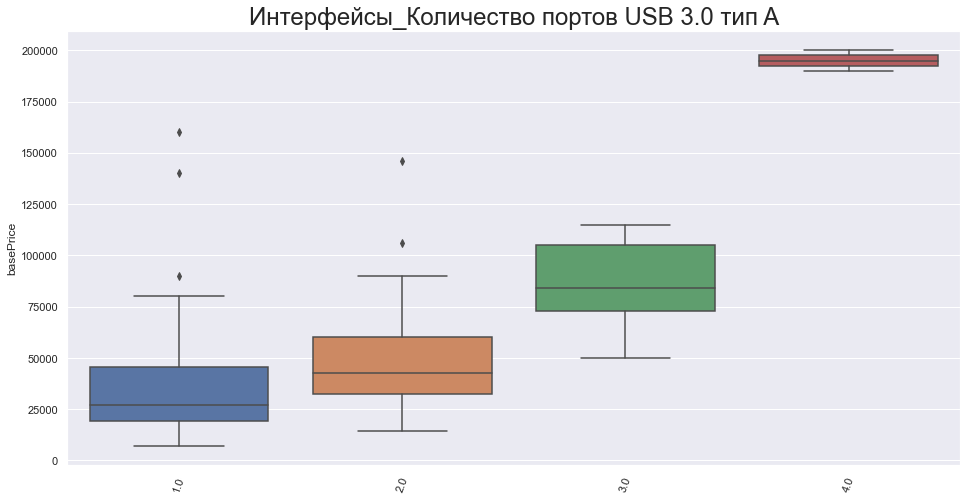

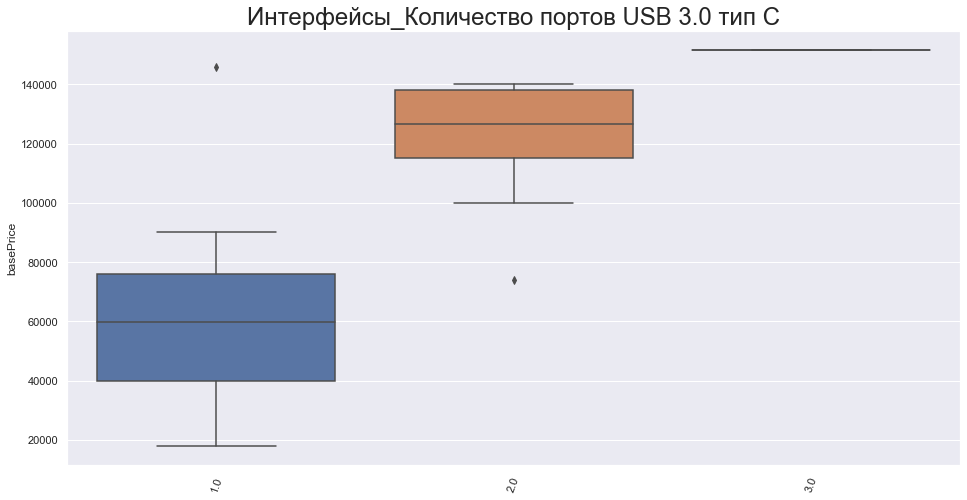

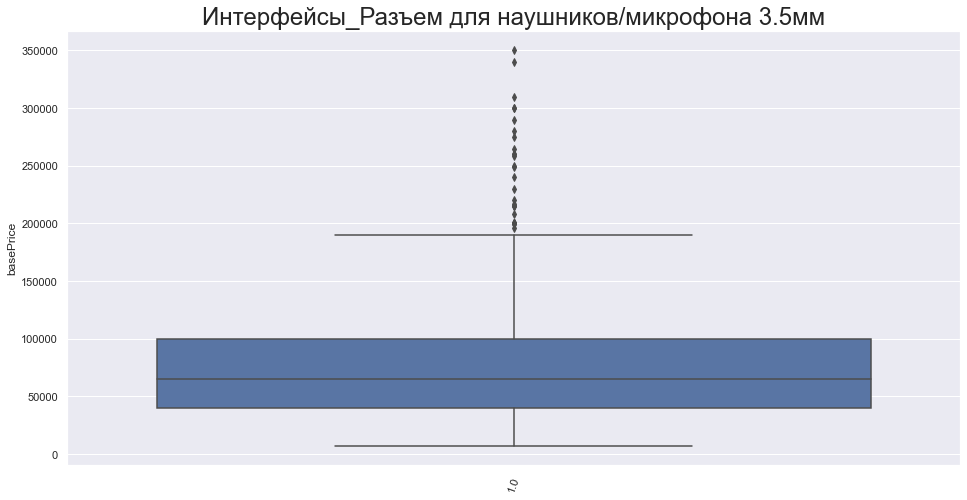

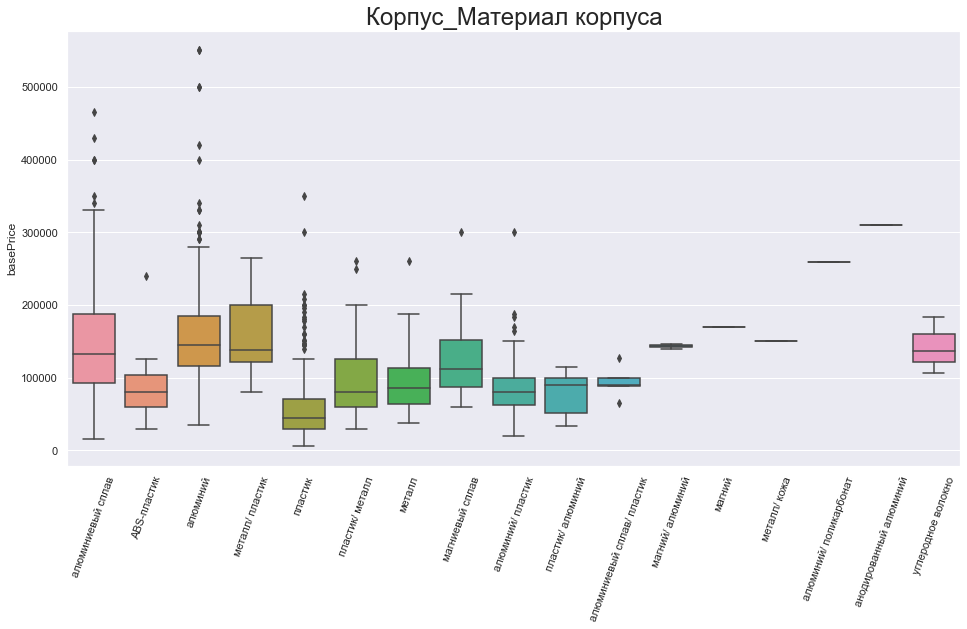

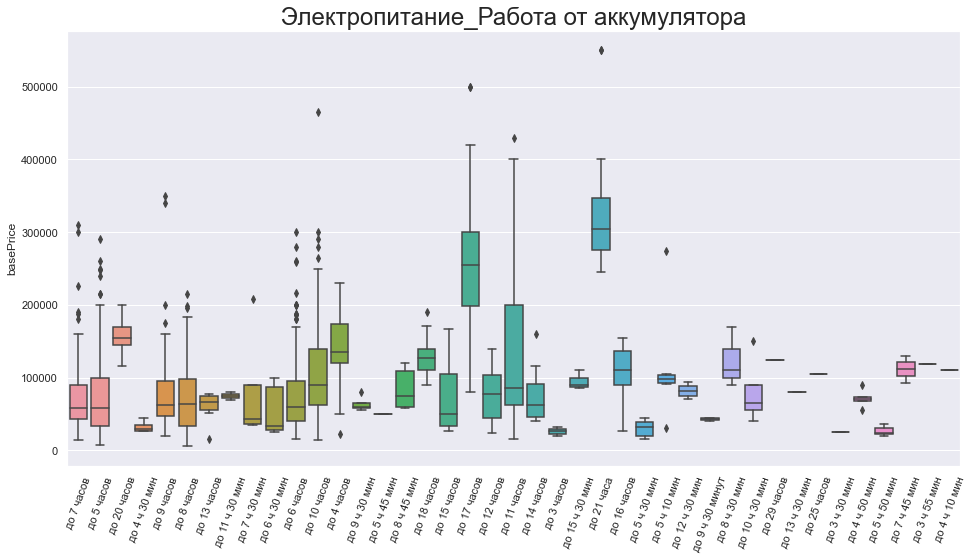

In [53]:
for feature in list(current_features):
    analyze_cat_feature(feature)

## Датчик отпечатков пальцев
Если признака нет, то и датчика нету

In [54]:
df["Безопасность_Датчик отпечатков пальцев"].value_counts()

Да    263
Name: Безопасность_Датчик отпечатков пальцев, dtype: int64

In [55]:
df["Безопасность_Датчик отпечатков пальцев_crop"] = ~df["Безопасность_Датчик отпечатков пальцев"].isna()

## Материал корпуса

In [56]:
df["Корпус_Материал корпуса"].value_counts()

пластик                       411
алюминий                      202
алюминиевый сплав              86
металл                         66
алюминий/ пластик              53
пластик/ металл                47
металл/ пластик                16
пластик/ алюминий              15
ABS-пластик                    10
магниевый сплав                 8
алюминиевый сплав/ пластик      7
углеродное волокно              3
магний/ алюминий                2
магний                          1
металл/ кожа                    1
алюминий/ поликарбонат          1
анодированный алюминий          1
Name: Корпус_Материал корпуса, dtype: int64

In [57]:
df["Корпус_Материал корпуса_металл"] = df["Корпус_Материал корпуса"].str.contains("алюмин|металл|сплав|магний")

In [58]:
df["Корпус_Материал корпуса_пластик"] = df["Корпус_Материал корпуса"].str.contains("пластик|углерод|поликарб")

In [59]:
useful_features.update([
    "Безопасность_Датчик отпечатков пальцев_crop",
    "Корпус_Материал корпуса_металл",
    "Корпус_Материал корпуса_пластик"
])


In [60]:
df[list(useful_features) + ["basePrice"]].to_parquet("clean_data.v1.parquet")